## Import required libraries

In [1]:
import pandas as pd
import numpy as np
import json
# plotting
import os
import pathlib
import warnings
import statsmodels.api as sm
import statsmodels.formula.api as smf
from mplsoccer import Pitch
import matplotlib.pyplot as plt
import glob
import math
from itertools import combinations_with_replacement
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor,XGBClassifier
from sklearn.linear_model import LinearRegression

pd.options.mode.chained_assignment = None
warnings.filterwarnings('ignore')

## Import all events per Man City's matches

In [2]:
# Define the wildcard pattern to match the file names
pattern = '../data/StatsBomb/Data/*_events.json'
# Use glob to find all files that match the pattern
file_list = glob.glob(pattern)

match_game = '_'.join(file_list[0].split('/')[-1].split('_')[:2])

df_list = []
for file in file_list:
    # Open the file and load its contents into a dictionary
    with open(file, 'r') as f:
        data = json.load(f)
        match_game = '_'.join(file.split('/')[-1].split('_')[:2])
        df_game = pd.json_normalize(data)
        df_game['match_game'] = match_game
        # Convert the list of JSON values to a DataFrame
        df_list.append(df_game)

In [3]:
df = pd.concat(df_list,ignore_index = True)

match_games = df['match_game'].unique()
df_games = {game:df[df['match_game']==game] for game in match_games}

In [4]:
example_match = match_games[0]

## Preparing data

First we see create a new column with the next event. We create a column with 1 if the ball was kicked out - to mark when the chain should be stopped. We filter out Interruptions since there was an ball out of the pitch or foul before them. Then, we filter lost duels, since Wyscout duels are saved twice - for both team either defensive or offensive. We filter out events “Out of ball” since we can get this information from other column. Then, we filter out events by goalkeepers, since shots were made before.


- Create a new column with the next event
- Create a column with 1 if the ball was kicked out - to mark when the chain should be stopped
- Filter out Interruptions since there was an ball out of the pitch or foul before them

In [5]:
next_event = {match_game:df_games[match_game].shift(-1, fill_value=0) for match_game in df_games.keys()}

In [6]:
for match_game in df_games.keys():
    df_games[match_game]['nextEvent'] = next_event[match_game]['type.name']
    df_games[match_game]['kickedOut'] = np.where(next_event[match_game]['out']==True,1,0)

In [7]:
# df["nextEvent"] = next_event["type.name"]
# df['kickedOut'] = np.where(next_event['out']==True,1,0)

In [8]:
keepEvents = \
[
    'Carry',
    'Pass',
    'Duel',
    'Dribble',
    'Clearance',
    'Shot',
    'Foul',
    'Foul Committed',
    'Injury Stoppage',
    'Foul',
    'Substitution',
    'Offside',
    'Interception',
    'Ball Recovery',
    'Ball Receipt*'
]

In [9]:
cl_df = {match_game:df_games[match_game][df_games[match_game]['type.name'].isin(keepEvents)] for match_game in df_games.keys()}

## Isolating possesion chain
- Isolate possesion chain with the rule that if the ball was touched once by a different team, it should not change the results.
- If there was a foul, ball kicked out of the field the chain is stopped.
- For others in the ball, if the ball was properly intercepted that is, the next team is the one that made the next event, we stop the chain.
- Otherwise, if the ball was only touched, but did not change possesion, we treat a pass as an accurate one.
- This is an approximate of true possesion chain.

In [10]:
# cl_df['match_game'].value_counts()
for match_game in cl_df.keys():
    print(f'Match Game: {match_game}  Events: {len(cl_df[match_game])}')

Match Game: ManCity_Tottenham  Events: 3219
Match Game: ManCity_AstonVilla  Events: 2833
Match Game: ManCity_Liverpool  Events: 2642
Match Game: ManCity_Brighton  Events: 3425
Match Game: ManCity_Arsenal  Events: 3060
Match Game: ManCity_LeicesterCity  Events: 3004


In [11]:
def timestamp_to_seconds(timestamp):
    parts = timestamp.split(':')
    hours = int(parts[0])
    minutes = int(parts[1])
    seconds = float(parts[2])
    total_seconds = (hours * 3600) + (minutes * 60) + seconds
    return int(total_seconds)


In [12]:
def isolateChains(df):
    """
    Parameters
    ----------
    df : dataframe
        dataframe with StatsBomb event data.

    Returns
    -------
    df: dataframe
        dataframe with isolated possesion chains

    """
    df['seconds'] = df['timestamp'].apply(lambda time: timestamp_to_seconds(time))
    df["nextTeamName"] = df.shift(-1, fill_value=0)["team.name"]
    #potential +0s
    chain_team = df.iloc[0]["team.name"]
    period = df.iloc[0]["period"]
    stop_criterion = 0
    chain = 0
    df["possesion_chain"] = 0
    df["possesion_chain_team"] = 0

    for i, row in df.iterrows():
        # if (row['index']==283):
        #     import pdb;pdb.set_trace()
        #add value
        df.at[i, "possesion_chain"] = chain
        df.at[i, "possesion_chain_team"] = chain_team

        if row['team.name'] != chain_team:
            stop_criterion+=1
        if row["type.name"] in ["Shot", "Foul Committed", "Offside",'Injury Stoppage','Substitution']:
            stop_criterion += 2
        if row['type.name'] == 'Ball Receipt*':
            if row['ball_receipt.outcome.name'] == 'Incomplete':
                stop_criterion +=2
        #if ball out of field, add 2
        if row["out"]==True:
            stop_criterion += 2
        # if the ball was properly intercepted that is, the next team is the one that made the next event, we stop the chain.         
        if row['type.name']=='Interception':
            if row['team.name']!=row['nextTeamName']:
                stop_criterion +=2
            else:
                # if the ball was only touched, but did not change possesion, we treat a pass as an accurate one.
                stop_criterion = 0
  
        if stop_criterion == 1 and row['team.name'] == chain_team:
            stop_criterion = 0 
        #criterion for stopping when half ended
        
        if row["period"] != period:
                chain += 1
                stop_criterion = 0
                chain_team = row['team.name']
                period = row["period"]
                df.at[i, "possesion_chain"] = chain
                df.at[i, "possesion_chain_team"] = chain_team
        #possesion chain ended
        if stop_criterion >= 2:
            chain += 1
            stop_criterion = 0
            chain_team = row['nextTeamName']
    return df


In [13]:
df_isolated = {match_game:isolateChains(cl_df[match_game]) for match_game in cl_df.keys()}

In [14]:
for match_game in match_games:
    df_list = []
    for possession in df_isolated[match_game]['possesion_chain'].unique():
        temp_df = df_isolated[match_game][df_isolated[match_game]['possesion_chain']==possession]
        temp_df = temp_df[temp_df['seconds']>= max(temp_df['seconds']-15)]
        df_list.append(temp_df)
    df_isolated[match_game] = pd.concat(df_list)

## Retrieve all Possesion Chain that lead to a shot per game

In [15]:
chains_index = {match_game:df_isolated[match_game][df_isolated[match_game]['type.name']=='Shot']['possesion_chain'].unique() for match_game in df_isolated.keys()}


In [16]:
shot = {match_game:df_isolated[match_game][df_isolated[match_game]['type.name']=='Shot'] for match_game in df_isolated.keys()}


In [17]:
for match_game in df_isolated.keys():
    df_isolated[match_game]['end_location'] = df_isolated[match_game]['carry.end_location'].fillna(df_isolated[match_game]['shot.end_location']).fillna(df_isolated[match_game]['pass.end_location'])


In [18]:
shot_patterns = \
{
    match_game : 
    df_isolated[match_game][
        df_isolated[match_game]['possesion_chain'].isin(chains_index[match_game])][
        ['type.name','location','end_location','possesion_chain','team.name','index','shot.statsbomb_xg','match_game','seconds']
    ]
for match_game in df_isolated.keys()
}

In [19]:
for match_game in df_isolated.keys():
    shot_patterns[match_game]['shot.statsbomb_xg'] = shot_patterns[match_game]['shot.statsbomb_xg'].fillna(0.0)

In [20]:
shot_patterns[match_games[0]]['possesion_chain'].unique()

array([  1,  10,  17,  19,  21,  27,  33,  43,  44,  45,  47,  55,  57,
        73,  84,  96, 117, 121, 134, 140, 145, 150, 209, 210, 230, 239,
       279, 280, 282, 283, 284, 293, 297, 305, 318, 323])

In [21]:
shot_patterns[match_games[0]][shot_patterns[match_games[0]]['possesion_chain']==17]

,type.name,location,end_location,possesion_chain,team.name,index,shot.statsbomb_xg,match_game,seconds
196,Ball Receipt*,"[104.8, 21.0]",NaN,17,Manchester City WFC,197,0.00000,ManCity_Tottenham,253
197,Carry,"[104.8, 21.0]","[100.7, 18.7]",17,Manchester City WFC,198,0.00000,ManCity_Tottenham,253
200,Pass,"[100.7, 18.7]","[104.3, 5.2]",17,Manchester City WFC,201,0.00000,ManCity_Tottenham,258
201,Ball Receipt*,"[104.3, 5.2]",NaN,17,Manchester City WFC,202,0.00000,ManCity_Tottenham,259
202,Carry,"[104.3, 5.2]","[102.8, 12.3]",17,Manchester City WFC,203,0.00000,ManCity_Tottenham,259
205,Duel,"[17.3, 67.8]",NaN,17,Tottenham Hotspur Women,206,0.00000,ManCity_Tottenham,261
206,Ball Recovery,"[99.5, 13.0]",NaN,17,Manchester City WFC,207,0.00000,ManCity_Tottenham,262
207,Carry,"[99.5, 13.0]","[103.8, 19.1]",17,Manchester City WFC,208,0.00000,ManCity_Tottenham,262
209,Dribble,"[103.8, 19.1]",NaN,17,Manchester City WFC,210,0.00000,ManCity_Tottenham,264
210,Duel,"[16.3, 61.0]",NaN,17,Tottenham Hotspur Women,211,0.00000,ManCity_Tottenham,264


In [22]:
shot_patterns_df = {}
for match_game in shot_patterns.keys():
    patterns_list = [] 
    for c_index in chains_index[match_game]:
        temp_df = shot_patterns[match_game][shot_patterns[match_game]['possesion_chain']==c_index]
        temp_df['xGoal'] = max(temp_df['shot.statsbomb_xg'])
        patterns_list.append(temp_df)
    shot_patterns_df[match_game] = pd.concat(patterns_list)

## Finding chains that ended with shot

In [23]:
def prepareChains(df):
    """
    Parameters
    ----------
    df : dataframe
        dataframe with Wyscout event data.

    Returns
    -------
    xG_sum: dataframe
        dataframe with assigned values for chains

    """
    # import pdb;pdb.set_trace()
    df["shot_end"] = 0
    df['xG'] = np.where(df['shot.statsbomb_xg'].isna(),0,df['shot.statsbomb_xg'])
    #get number of chains
    no_chains = max(df["possesion_chain"].unique())
    indicies = []
    for i in range(no_chains+1):
        #all events get possesion chain
        possesion_chain_df = df.loc[df["possesion_chain"] == i]
        #check if the possesion chain is not empty
        if len(possesion_chain_df) > 0:
            #if ended with shot
            if possesion_chain_df.iloc[-1]["type.name"] == "Shot":
                #assign values
                df.loc[df["possesion_chain"] == i, "shot_end"] = 1
                xG = possesion_chain_df.iloc[-1]["xG"]
                df.loc[df["possesion_chain"] == i, "xG"] = xG
                #check if the previous ones did not end with foul
                k = i-1
                if k > 0:
                    try:
                        prev = df.loc[df["possesion_chain"] == k]
                        #create a loop if e.g. 2 chains before and 1 chain before didn;t end with shot
                        while prev.iloc[-1]["type.name"] == "Foul":
                            #assign value for them
                            df.loc[df["possesion_chain"] == k, "xG"] = xG
                            df.loc[df["possesion_chain"] == k, "shot_end"] = 1
                            k = k-1
                            prev = df.loc[df["possesion_chain"] == k]
                    except:
                        k = k-1
            #get indiices of events made by possesion team
            team_indicies = possesion_chain_df.loc[possesion_chain_df["team.id"] == possesion_chain_df['possession_team.id']].index.values.tolist()
            indicies.extend(team_indicies)

    df = df.loc[indicies]
    return df

In [24]:
df_isolated_chains = {}
for match_game in match_games:
    df_isolated_chains[match_game] = prepareChains(df_isolated[match_game])

In [25]:
shot_patterns['ManCity_Tottenham']['possesion_chain'].unique()

array([  1,  10,  17,  19,  21,  27,  33,  43,  44,  45,  47,  55,  57,
        73,  84,  96, 117, 121, 134, 140, 145, 150, 209, 210, 230, 239,
       279, 280, 282, 283, 284, 293, 297, 305, 318, 323])

## Preparing data for modelling

In [26]:
shot_patterns_df_copy = df_isolated_chains.copy()

In [27]:
def prepare_coordinates(shot_patterns_df):
    #columns with coordinates
    shot_patterns_df = shot_patterns_df[~shot_patterns_df['end_location'].isna()]
    shot_patterns_df["x0"] = shot_patterns_df.location.apply(lambda cell: (cell[0]))
    shot_patterns_df["c0"] = shot_patterns_df.location.apply(lambda cell: abs(60 - cell[1]))
    shot_patterns_df["x1"] = shot_patterns_df.end_location.apply(lambda cell: (cell[0]))
    shot_patterns_df["c1"] = shot_patterns_df.end_location.apply(lambda cell: abs(60 - cell[1]))
    #assign (105, 0) to end of the shot
    shot_patterns_df.loc[df["type.name"] == "Shot", "x1"] = 120
    shot_patterns_df.loc[df["type.name"] == "Shot", "c1"] = 0

    #for plotting
    shot_patterns_df["y0"] = shot_patterns_df.location.apply(lambda cell: (cell[1]))
    shot_patterns_df["y1"] = shot_patterns_df.end_location.apply(lambda cell: (cell[1]))
    shot_patterns_df.loc[df["type.name"] == "Shot", "y1"] = 40
    shot_patterns_df['end_shot'] = 1
    return shot_patterns_df

In [28]:
shot_patterns_df_copy.keys()

dict_keys(['ManCity_Tottenham', 'ManCity_AstonVilla', 'ManCity_Liverpool', 'ManCity_Brighton', 'ManCity_Arsenal', 'ManCity_LeicesterCity'])

In [29]:
shot_patterns_df = {match_game:prepare_coordinates(shot_patterns_df[match_game]) for match_game in shot_patterns_df.keys()}

## Possesion chain that ended with a shot

In [30]:
shot_patterns_df[match_games[0]][shot_patterns_df[match_games[0]]['possesion_chain']==10]

,type.name,location,end_location,possesion_chain,team.name,index,shot.statsbomb_xg,match_game,seconds,xGoal,x0,c0,x1,c1,y0,y1,end_shot
127,Pass,"[96.5, 43.5]","[92.4, 49.7]",10,Manchester City WFC,128,0.000000,ManCity_Tottenham,141,0.089495,96.5,16.5,92.4,10.3,43.5,49.7,1
129,Carry,"[92.4, 49.7]","[92.4, 49.7]",10,Manchester City WFC,130,0.000000,ManCity_Tottenham,141,0.089495,92.4,10.3,92.4,10.3,49.7,49.7,1
130,Pass,"[92.4, 49.7]","[85.1, 54.9]",10,Manchester City WFC,131,0.000000,ManCity_Tottenham,142,0.089495,92.4,10.3,85.1,5.1,49.7,54.9,1
132,Carry,"[85.1, 54.9]","[85.1, 54.9]",10,Manchester City WFC,133,0.000000,ManCity_Tottenham,143,0.089495,85.1,5.1,85.1,5.1,54.9,54.9,1
133,Pass,"[85.1, 54.9]","[78.7, 20.6]",10,Manchester City WFC,134,0.000000,ManCity_Tottenham,144,0.089495,85.1,5.1,78.7,39.4,54.9,20.6,1
135,Carry,"[78.7, 20.6]","[78.7, 20.6]",10,Manchester City WFC,136,0.000000,ManCity_Tottenham,145,0.089495,78.7,39.4,78.7,39.4,20.6,20.6,1
136,Pass,"[78.7, 20.6]","[93.9, 5.0]",10,Manchester City WFC,137,0.000000,ManCity_Tottenham,146,0.089495,78.7,39.4,93.9,55.0,20.6,5.0,1
138,Carry,"[93.9, 5.0]","[115.1, 13.0]",10,Manchester City WFC,139,0.000000,ManCity_Tottenham,147,0.089495,93.9,55.0,115.1,47.0,5.0,13.0,1
139,Pass,"[115.1, 13.0]","[112.5, 34.2]",10,Manchester City WFC,140,0.000000,ManCity_Tottenham,153,0.089495,115.1,47.0,112.5,25.8,13.0,34.2,1
141,Shot,"[112.5, 34.2, 0.5]","[120.0, 29.5, 0.9]",10,Manchester City WFC,142,0.089495,ManCity_Tottenham,154,0.089495,112.5,25.8,120.0,0.0,34.2,40.0,1


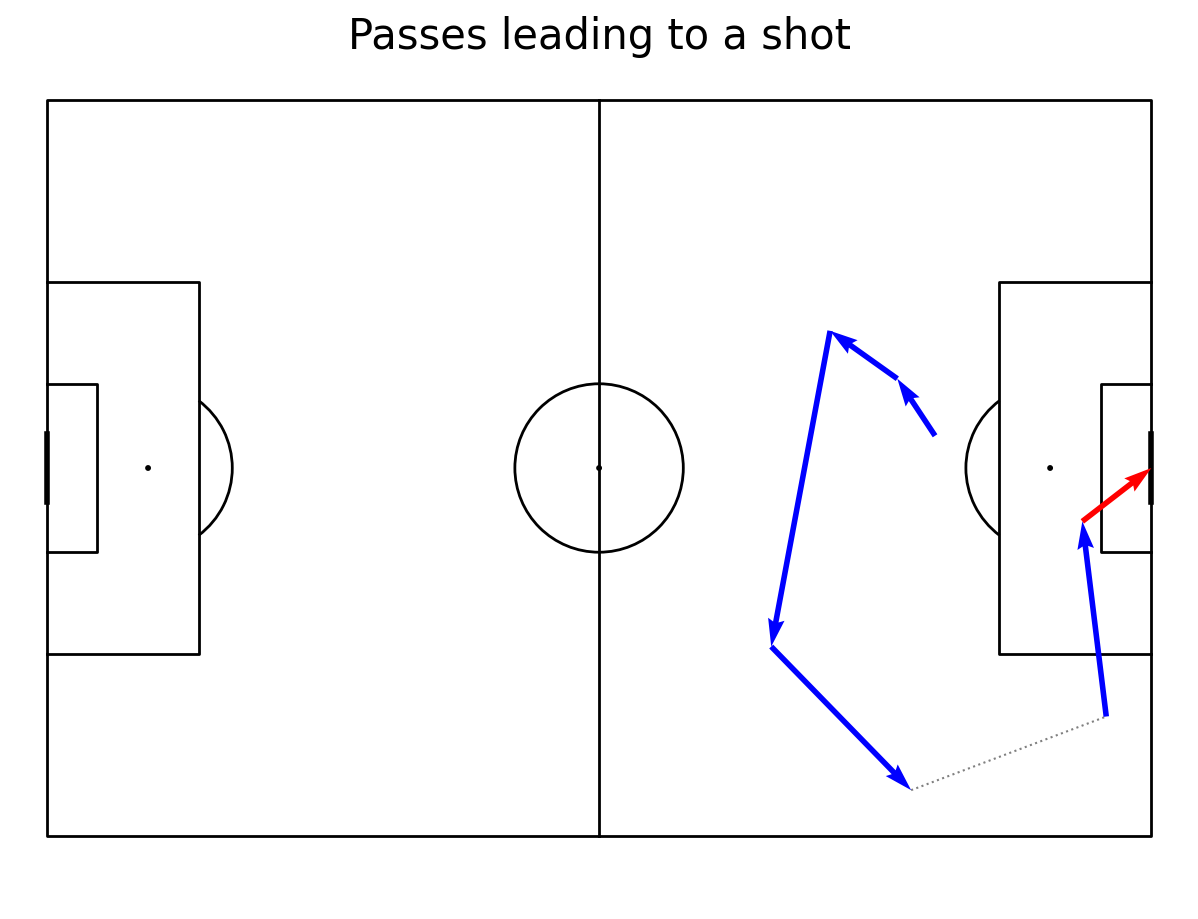

In [31]:
#plot possesion chain that ended with shot
chain = shot_patterns_df[example_match].loc[shot_patterns_df[example_match]["possesion_chain"] == 10]
#get passes
passes = chain.loc[chain["type.name"].isin(["Pass"])]
#get events different than pass
not_pass = chain.loc[chain["type.name"] != "Pass"].iloc[:-1]
#shot is the last event of the chain (or should be)
shot = chain.iloc[-1]
#plot
pitch = Pitch(line_color='black',pitch_type='custom', pitch_length=120, pitch_width=80, line_zorder = 2)
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)
#passes
pitch.arrows(passes.x0, passes.y0,
            passes.x1, passes.y1, color = "blue", ax=ax['pitch'], zorder =  3)
#shot
pitch.arrows(shot.x0, shot.y0,
            shot.x1, shot.y1, color = "red", ax=ax['pitch'], zorder =  3)
#other passes like arrows
pitch.lines(not_pass.x0, not_pass.y0, not_pass.x1, not_pass.y1, color = "grey", lw = 1.5, ls = 'dotted', ax=ax['pitch'])
ax['title'].text(0.5, 0.5, 'Passes leading to a shot', ha='center', va='center', fontsize=30)
plt.show()

## Possesion chain that did not end with a shot

In [32]:
not_pass_index = {match_game:np.setdiff1d(df_isolated_chains[match_game]['possesion_chain'].unique(),chains_index[match_game]) for match_game in match_games}


In [33]:
not_pass_patterns_df = \
{
    match_game:
    df_isolated_chains[match_game][df_isolated_chains[match_game]['possesion_chain'].isin(not_pass_index[match_game])][
        ['type.name','location','end_location','possesion_chain','team.name','index','match_game']
    ]
    for match_game in match_games
}

In [34]:
def prepare_coordinates_not_pass(not_pass_patterns_df):
    #columns with coordinates
    not_pass_patterns_df = not_pass_patterns_df[~not_pass_patterns_df['end_location'].isna()]
    not_pass_patterns_df["x0"] = not_pass_patterns_df.location.apply(lambda cell: (cell[0]))
    not_pass_patterns_df["c0"] = not_pass_patterns_df.location.apply(lambda cell: abs(60 - cell[1]))
    not_pass_patterns_df["x1"] = not_pass_patterns_df.end_location.apply(lambda cell: (cell[0]))
    not_pass_patterns_df["c1"] = not_pass_patterns_df.end_location.apply(lambda cell: abs(60 - cell[1]))

    not_pass_patterns_df["y0"] = not_pass_patterns_df.location.apply(lambda cell: (cell[1]))
    not_pass_patterns_df["y1"] = not_pass_patterns_df.end_location.apply(lambda cell: (cell[1]))
    not_pass_patterns_df['end_shot'] = 0 
    return not_pass_patterns_df

In [35]:
not_pass_patterns_df = \
{
    match_game:
    prepare_coordinates_not_pass(not_pass_patterns_df[match_game]) 
    for match_game in not_pass_patterns_df.keys()
}

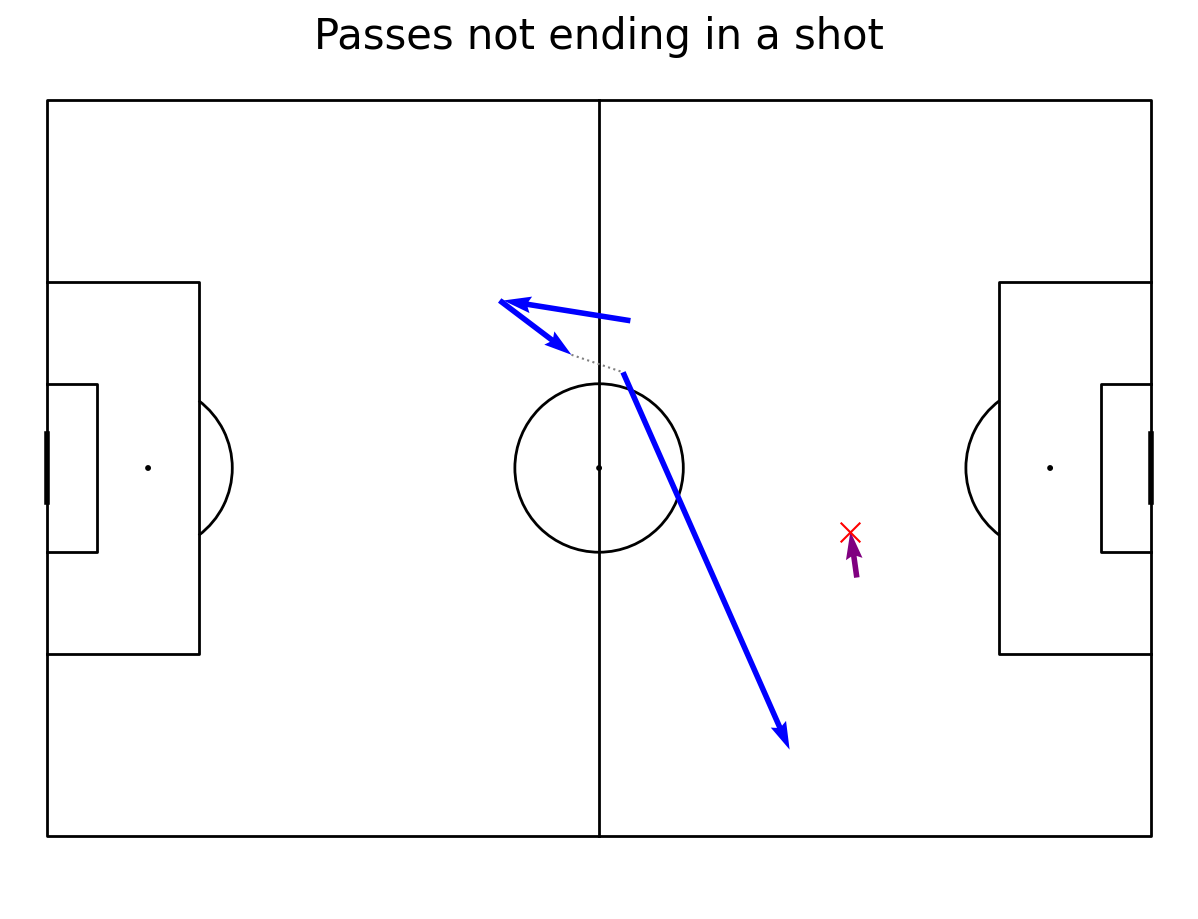

In [36]:
#plot possesion chain that ended with shot
chain = not_pass_patterns_df[example_match].loc[not_pass_patterns_df[example_match]["possesion_chain"] == not_pass_index[example_match][18]]
passes = chain.loc[chain["type.name"].isin(["Pass", "Foul Committed"])].iloc[:-1]
not_pass = chain.loc[(chain["type.name"] != "Pass") & (chain["type.name"] != "Foul Committed")].iloc[:-1]
bad_pass = chain.iloc[-1]
#we could have used better
pitch = Pitch(line_color='black',pitch_type='custom', pitch_length=120, pitch_width=80, line_zorder = 2)
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)
pitch.arrows(passes.x0, passes.y0,
            passes.x1, passes.y1, color = "blue", ax=ax['pitch'], zorder =  3)
pitch.arrows(bad_pass.x0, bad_pass.y0,
            bad_pass.x1, bad_pass.y1, color = "purple", ax=ax['pitch'], zorder =  3)
pitch.scatter(bad_pass.x1, bad_pass.y1, marker = 'x', color = "red", ax=ax['pitch'], zorder =  3, s= 200)
pitch.lines(not_pass.x0, not_pass.y0, not_pass.x1, not_pass.y1, color = "grey", lw = 1.5, ls = 'dotted', ax=ax['pitch'])
ax['title'].text(0.5, 0.5, 'Passes not ending in a shot', ha='center', va='center', fontsize=30)
plt.show()


## Preparing variables for models

In [37]:
df_poss_chain = pd.concat([df_isolated_chains[match_game] for match_game in match_games])

In [38]:
df_poss_chain.shape

(11083, 150)

In [39]:
df_poss_chain_shot = prepare_coordinates(df_poss_chain[df_poss_chain['shot_end']==1])

df_poss_chain_not_shot = prepare_coordinates_not_pass(df_poss_chain[df_poss_chain['shot_end']==0])

df_coordinates = pd.concat([df_poss_chain_shot,df_poss_chain_not_shot])

In [40]:
df_coordinates.shape

(6771, 157)

In [41]:
#model variables
var = ["x0", "x1", "c0", "c1"]

#combinations
inputs = []
#one variable combinations
inputs.extend(combinations_with_replacement(var, 1))
#2 variable combinations
inputs.extend(combinations_with_replacement(var, 2))
#3 variable combinations
inputs.extend(combinations_with_replacement(var, 3))

#make new columns
for i in inputs:
    #columns length 1 already exist
    if len(i) > 1:
        #column name
        column = ''
        x = 1
        for c in i:
            #add column name to be x0x1c0 for example
            column += c
            #multiply values in column
            x = x*df_coordinates[c]
        #create a new column in df
        df_coordinates[column] = x
        #add column to model variables
        var.append(column)
#investigate 3 columns
df_coordinates[var[-3:]].head(3)

,c0c0c1,c0c1c1,c1c1c1
16,46677.573,65872.089,92959.677
17,114917.040,142060.800,175616.000
19,169030.400,162691.760,156590.819


## Calculating action-based Expected Threat values for passes
- XGB Classifier
- Using it we predict probability of a chain ending with a shot.
- Then, on chains that ended with a shot, we fit a linear regression to calculate the probability that a shot ended with a goal.
- Product of these 2 values is our action-based Expected Threat statistic

In [42]:
### TRAINING, it's not perfect ML procedure, but results in AUC 0.2 higher than Logistic Regression ###
passes = df_coordinates.loc[ df_coordinates["type.name"].isin(["Pass"])]
X = passes[var].values
y = passes["end_shot"].values

In [43]:
from collections import Counter
Counter(y)

Counter({1: 359, 0: 3287})

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 123, stratify = y)
xgb = XGBClassifier(n_estimators = 100, ccp_alpha=0, max_depth=4, min_samples_leaf=10,
                      random_state=123)

# Set the scale_pos_weight parameter to handle class imbalance
scale_pos_weight = sum(y_train == 0) / sum(y_train == 1)
xgb.set_params(scale_pos_weight=scale_pos_weight)

XGBClassifier(base_score=None, booster=None, callbacks=None, ccp_alpha=0,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, min_samples_leaf=10, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

In [45]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 123, stratify = y)
# xgb = XGBRegressor(n_estimators = 100, ccp_alpha=0, max_depth=4, min_samples_leaf=10,
#                       random_state=123)

In [46]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(estimator = xgb, X = X_train, y = y_train, cv = 10, n_jobs = -1)
print(np.mean(scores), np.std(scores))
xgb.fit(X_train, y_train)
print(xgb.score(X_train, y_train))
y_pred = xgb.predict(X_test)
print(xgb.score(X_test, y_test))

0.8466834087033879 0.019488787954199525
[22:55:49] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "ccp_alpha", "min_samples_leaf" } are not used.

0.9740932642487047
0.8164383561643835


In [47]:
y_pr = xgb.predict(X_test)

In [48]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_pred=y_pr,y_true=y_test))
print('\n')
print(confusion_matrix(y_pred=y_pr,y_true=y_test))

              precision    recall  f1-score   support

           0       0.92      0.87      0.90       329
           1       0.21      0.31      0.25        36

    accuracy                           0.82       365
   macro avg       0.56      0.59      0.57       365
weighted avg       0.85      0.82      0.83       365



[[287  42]
 [ 25  11]]


In [49]:
#predict if ended with shot
passes = df_coordinates.loc[df_coordinates["type.name"].isin(["Pass"])]
X = passes[var].values
y = passes["shot_end"].values
model = xgb
#predict probability of shot ended
y_pred_proba = model.predict_proba(X)[::,1]

In [50]:
passes["shot_prob"] = y_pred_proba
#OLS
shot_ended = passes.loc[passes["end_shot"] == 1]
X2 = shot_ended[var].values
y2 = shot_ended["xG"].values
lr = LinearRegression()
lr.fit(X2, y2)
y_pred = lr.predict(X)
passes["xG_pred"] = y_pred
#calculate xGchain
passes["xT"] = passes["xG_pred"]*passes["shot_prob"]

## Making a plot of pass values

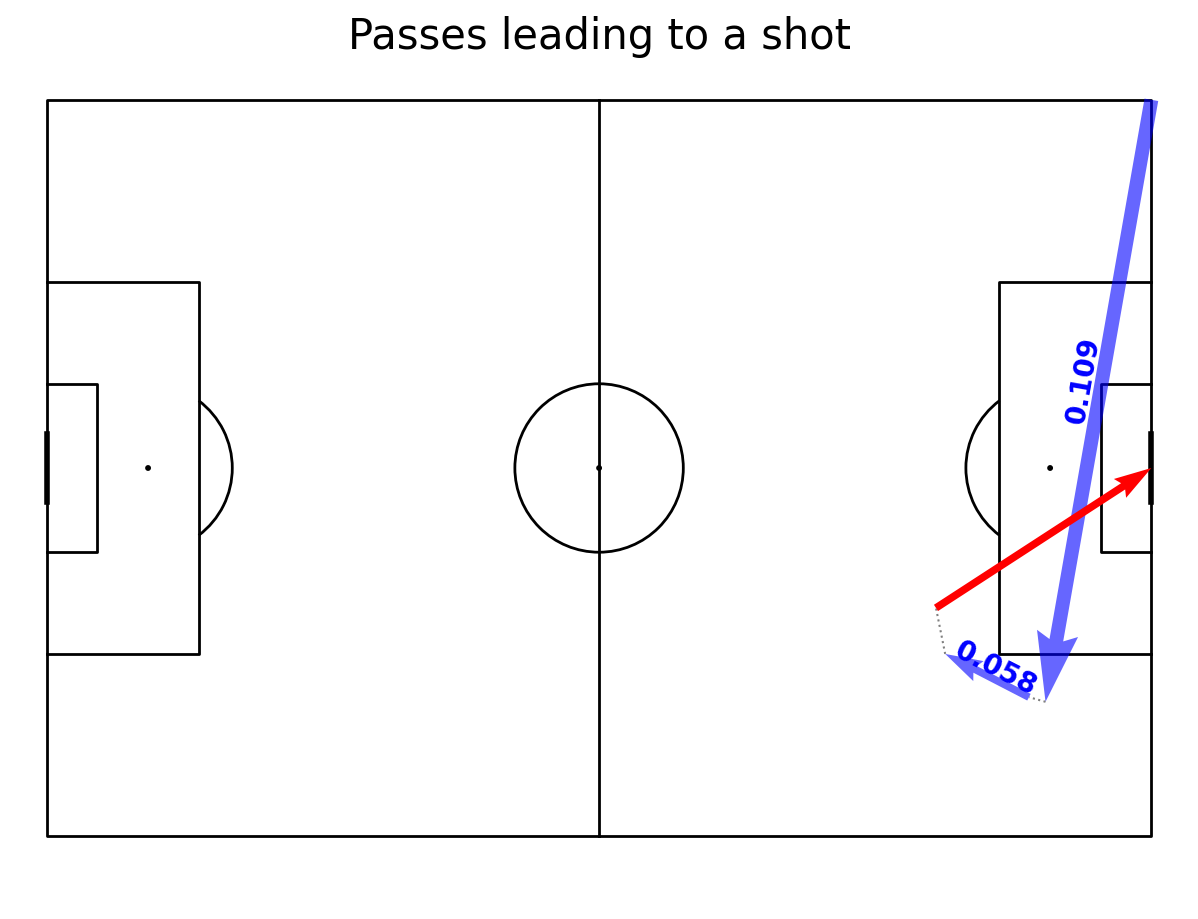

In [107]:
possession_example = chains_index['ManCity_Tottenham'][9]
# possession_example = 293

chain = df_coordinates.loc[ (df_coordinates["possesion_chain"] == possession_example) & (df_coordinates['match_game']== match_games[0])]

#get passes
passes_in = passes.loc[ 
    (passes["possesion_chain"] == possession_example) & (passes['match_game']==match_games[0])
]

max_value = passes_in["xT"].max()
#get events different than pass
not_pass = chain.loc[chain["type.name"] != "Pass"].iloc[:-1]
#shot is the last event of the chain (or should be)
shot = chain.iloc[-1]

#plot
pitch = Pitch(line_color='black',pitch_type='custom', pitch_length=120, pitch_width=80, line_zorder = 2)
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)
#add size adjusted arrows
for i, row in passes_in.iterrows():
    value = row["xT"]
    #adjust the line width so that the more passes, the wider the line
    line_width = (value / max_value * 10)
    #get angle
    angle = np.arctan((row.y1-row.y0)/(row.x1-row.x0))*180/np.pi
    #plot lines on the pitch
    pitch.arrows(row.x0, row.y0, row.x1, row.y1,
                        alpha=0.6, width=line_width, zorder=2, color="blue", ax = ax["pitch"])
    #annotate text
    ax["pitch"].text((row.x0+row.x1-8)/2, (row.y0+row.y1-4)/2, str(value)[:5], fontweight = "bold", color = "blue", zorder = 4, fontsize = 20, rotation = int(angle))

#shot
pitch.arrows(shot.x0, shot.y0,
            shot.x1, shot.y1, width=line_width, color = "red", ax=ax['pitch'], zorder =  3)
#other passes like arrows
pitch.lines(not_pass.x0, not_pass.y0, not_pass.x1, not_pass.y1, color = "grey", lw = 1.5, ls = 'dotted', ax=ax['pitch'])
ax['title'].text(0.5, 0.5, 'Passes leading to a shot', ha='center', va='center', fontsize=30)
plt.show()

## Finding out players with highest action-based Expected Threat

In [56]:
summary = passes[["player.id", "player.name" , "xT", "possesion_chain"]].groupby(["player.id", "player.name"]).sum().reset_index()

In [57]:
summary = passes.groupby(["player.id", "player.name"]).agg({
    "xT": ["sum"],
    "possesion_chain" : ["nunique"]
})

In [58]:
# Rename columns for clarity
summary.columns = ["xT","pass_count"]
summary.reset_index(inplace=True)

In [68]:
summary['player.name'] = summary['player.name'].apply(lambda fullname: fullname.title())

### Retrieve the minutes played by each player for each match

In [69]:
def collect_json(pattern):
    # Use glob to find all files that match the pattern
    file_list = glob.glob(pattern)

    match_game = '_'.join(file_list[0].split('/')[-1].split('_')[:2])

    json_dic = {}
    for file in file_list:
        # Open the file and load its contents into a dictionary
        with open(file, 'r') as f:
            data = json.load(f)
            match_game = '_'.join(file.split('/')[-1].split('_')[:2])
            json_dic[match_game] = {
                data[0]['team_name'] : data[0],
                data[1]['team_name'] : data[1]
            }
    return json_dic

In [70]:
lineups_dic = collect_json(pattern='../data/StatsBomb/Data/*_lineups.json')

In [71]:
players_dic_list = []
for match in lineups_dic.keys():
    for team in lineups_dic[match].keys():
        for player in lineups_dic[match][team]['lineup']:
            for position in player['positions']:
                # print(f"{match} {team} {player['player_name']} {position['position']} {position['from']} {position['to'] if position['to'] is not None else '01:35:00.000'}")
                players_dic_list.append(
                    {
                        'match' : match,
                        'team' : team,
                        'player_name' : player['player_name'],
                        'position' : position['position'],
                        'from' : position['from'],
                        'to' : position['to'] if position['to'] is not None else '01:35:00.000'
                    }
                )
            

In [72]:
# convert list of dictionaries to DataFrame
players_df = pd.DataFrame(players_dic_list)

# convert timestamp column to timedelta format
players_df['from_timedelta'] = pd.to_timedelta(players_df['from'])
players_df['to_timedelta'] = pd.to_timedelta(players_df['to'])

# calculate total seconds elapsed since midnight
players_df['from_seconds'] = players_df['from_timedelta'].dt.total_seconds()
players_df['to_seconds'] = players_df['to_timedelta'].dt.total_seconds()

# convert seconds to minutes
players_df['from_minutes'] = players_df['from_seconds'] / 60
players_df['to_minutes'] = players_df['to_seconds'] / 60

players_df['minutes_played'] = players_df['to_minutes'].astype(int) - players_df['from_minutes'].astype(int)
players_df['player_name'] = players_df['player_name'].apply(lambda name: name.title())

In [73]:
players_df_minutes = players_df[['match','team','player_name','position','minutes_played']]

In [74]:
minutes_player = players_df_minutes.groupby(['team','player_name']).sum(['minutes_played']).reset_index()

In [75]:
summary_players_minutes = \
pd.merge(
    summary,
    minutes_player,
    left_on='player.name',
    right_on='player_name',
    how='left'
)

In [76]:
summary_players_minutes

,player.id,player.name,xT,pass_count,team,player_name,minutes_played
0,4637.0,Ellie Roebuck,0.649022,95,Manchester City WFC,Ellie Roebuck,570
1,4638.0,Drew Spence,0.530666,18,Tottenham Hotspur Women,Drew Spence,83
2,4649.0,Esme Beth Morgan,3.056029,93,Manchester City WFC,Esme Beth Morgan,282
3,4848.0,Ashleigh Neville,0.491476,20,Tottenham Hotspur Women,Ashleigh Neville,95
4,4865.0,Josie Green,0.060473,10,Leicester City WFC,Josie Green,68
...,...,...,...,...,...,...,...
95,135759.0,Shannon O’Brien,0.140021,6,Leicester City WFC,Shannon O’Brien,95
96,191851.0,Julie Blakstad,1.020455,26,Manchester City WFC,Julie Blakstad,121
97,221888.0,Kerstin Yasmijn Casparij,2.719362,111,Manchester City WFC,Kerstin Yasmijn Casparij,395
98,276443.0,Kathrine Møller Kühl,0.211311,10,Arsenal WFC,Kathrine Møller Kühl,28


### Calculate xThreat per 90 minutes (Filtering out players who played less than 90 minutes)

In [77]:
summary_players_minutes_p90 = summary_players_minutes.loc[summary_players_minutes["minutes_played"] > 90]
#calculating per 90
summary_players_minutes_p90["xT_p90"] = summary_players_minutes_p90["xT"]*90/summary_players_minutes_p90["minutes_played"]

In [78]:
#adjust per possesion
summary_players_minutes_p90["xT_adjusted_per_90"] = (summary_players_minutes_p90["xT"]/summary_players_minutes_p90["pass_count"])*90/summary_players_minutes_p90["minutes_played"]



In [79]:
summary_xT_p90 = summary_players_minutes_p90[['team','player.name','minutes_played','xT','xT_p90','xT_adjusted_per_90','pass_count']].sort_values(by='xT_p90',ascending=False).head(10)


In [80]:
summary_xT_p90

,team,player.name,minutes_played,xT,xT_p90,xT_adjusted_per_90,pass_count
27,Manchester City WFC,Chloe Kelly,457,6.368118,1.254115,0.012541,100
24,Manchester City WFC,Lauren Hemp,449,5.477096,1.097859,0.011436,96
2,Manchester City WFC,Esme Beth Morgan,282,3.056029,0.975328,0.010487,93
25,Aston Villa,Lucy Staniforth,95,1.001734,0.949012,0.025649,37
10,Manchester City WFC,Hayley Emma Raso,113,1.186384,0.944908,0.042950,22
16,Manchester City WFC,Alex Greenwood,556,5.558932,0.899827,0.005113,176
81,Manchester City WFC,Ingrid Filippa Angeldal,291,2.829549,0.875118,0.010939,80
96,Manchester City WFC,Julie Blakstad,121,1.020455,0.759016,0.029193,26
22,Aston Villa,Kenza Dali,95,0.794650,0.752826,0.026887,28
80,Manchester City WFC,Deyna Cristina Castellanos Naujenis,318,2.618978,0.741220,0.013004,57


In [81]:
players_positions = players_df_minutes[['player_name','position']].drop_duplicates(subset=['player_name'],keep='first')

In [82]:
pd.merge(
    summary_xT_p90,
    players_positions,
    left_on='player.name',
    right_on='player_name',
    how = 'inner'
)

,team,player.name,minutes_played,xT,xT_p90,xT_adjusted_per_90,pass_count,player_name,position
0,Manchester City WFC,Chloe Kelly,457,6.368118,1.254115,0.012541,100,Chloe Kelly,Right Wing
1,Manchester City WFC,Lauren Hemp,449,5.477096,1.097859,0.011436,96,Lauren Hemp,Left Wing
2,Manchester City WFC,Esme Beth Morgan,282,3.056029,0.975328,0.010487,93,Esme Beth Morgan,Right Center Back
3,Aston Villa,Lucy Staniforth,95,1.001734,0.949012,0.025649,37,Lucy Staniforth,Right Defensive Midfield
4,Manchester City WFC,Hayley Emma Raso,113,1.186384,0.944908,0.042950,22,Hayley Emma Raso,Right Wing
5,Manchester City WFC,Alex Greenwood,556,5.558932,0.899827,0.005113,176,Alex Greenwood,Left Center Back
6,Manchester City WFC,Ingrid Filippa Angeldal,291,2.829549,0.875118,0.010939,80,Ingrid Filippa Angeldal,Right Center Midfield
7,Manchester City WFC,Julie Blakstad,121,1.020455,0.759016,0.029193,26,Julie Blakstad,Left Wing
8,Aston Villa,Kenza Dali,95,0.794650,0.752826,0.026887,28,Kenza Dali,Left Defensive Midfield
9,Manchester City WFC,Deyna Cristina Castellanos Naujenis,318,2.618978,0.741220,0.013004,57,Deyna Cristina Castellanos Naujenis,Left Center Midfield
